In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [43]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [45]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most Recent Date: ", recent_date)

Most Recent Date:  2017-08-23


In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23 00:00:00


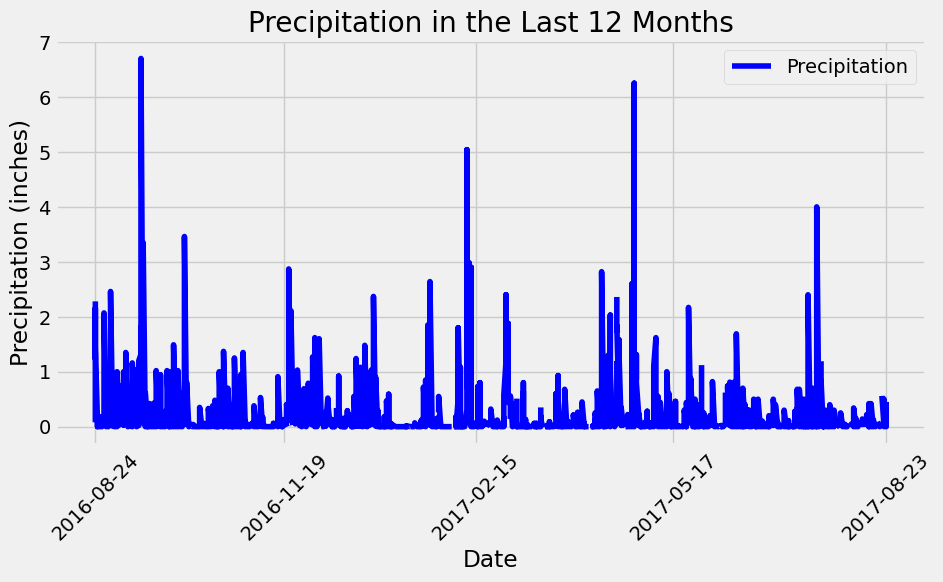

In [50]:
# Perform a query to retrieve the data and precipitation scores
past_twelve_months = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(past_twelve_months, columns=["date", "precipitation"])

# Set the index
precip_df.set_index("date", inplace=True)

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.plot(precip_df.index, precip_df["precipitation"], label="Precipitation", color="b")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
tick_indices = np.linspace(0, len(precip_df.index)-1,5, dtype=int)
plt.xticks(precip_df.index[tick_indices], rotation=45)
plt.legend()
plt.show()

In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precip_df.describe()
print(summary_stats)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [52]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(Station.station).count()
print(stations_count)

9


In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

for station, count in active_station:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_station[0][0]

temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station==most_active_station)
    .all()
)

print(temp_stats)

[(54.0, 85.0, 71.66378066378067)]


C:\Users\rmwc_\AppData\Local\Temp\ipykernel_14228\3361978215.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


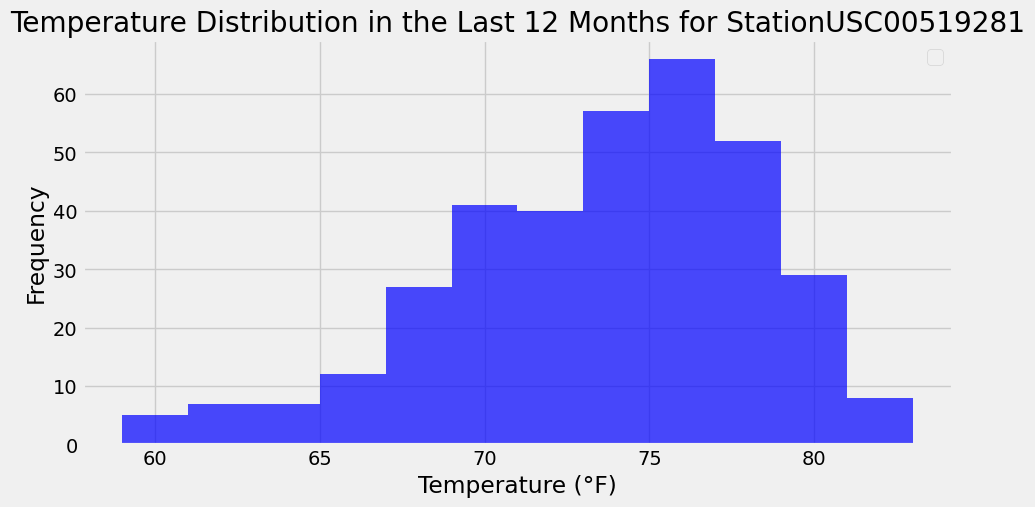

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_twelve_months_temp = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date >= one_year_ago)
    .filter(Measurement.station == most_active_station)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_df = pd.DataFrame(past_twelve_months_temp, columns=["date", "temperature"])

# Set the index
temp_df.set_index("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.hist(temp_df["temperature"], bins=12, color="b", alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Distribution in the Last 12 Months for Station{most_active_station}")
plt.legend()
plt.grid(True)
plt.show()

# Close Session

In [59]:
# Close Session
session.close()